In this notebook, we will
*  fetch Metadata from Sentinel-1.
*  use the Metadata to download the image(s). 
*  open, calibrate and speckle filter the image and 
* only take out the subsets that we need...

The reason why I preper this chronological order, is that I can use an external dataset to dictate which images to use. 


if you can use it, remember to see the License ;)


# Imports

In [1]:
from sentinel_1_python.metadata import Sentinel_metadata
from sentinel_1_python.visualize import show_cross_pol_function
from sentinel_1_python.download import Satellite_download
from sentinel_1_python.pre_process_grd import s1_load
import os, glob

## Metadata 

In [ ]:
with Sentinel_metadata() as met:
    met.area([29.9,21,56.7,58])
    met.get_metadata(sensor='s1_grd',start_data='20220109',end_date='20221010')

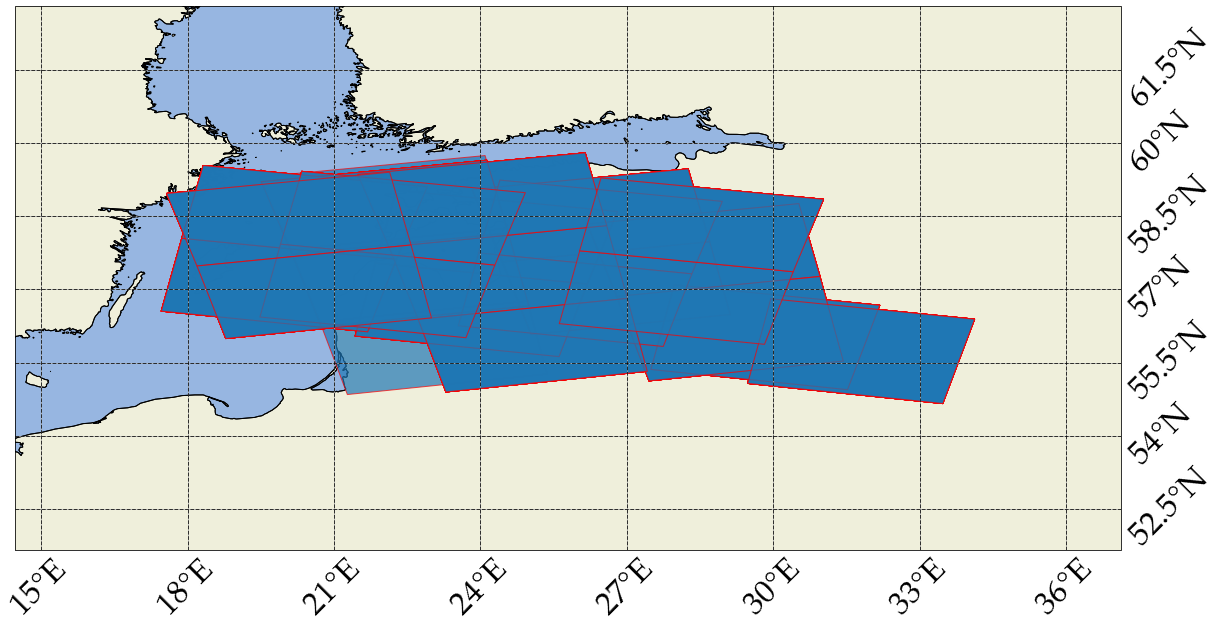

In [4]:
met.iw() #filer so we only have IW
met.plot_image_areas() # Showing extent of images

In [5]:
print(met.products_df.mgcs.unique()[5])
df_mgrs= met.products_df[met.products_df.mgcs==met.products_df.mgcs.unique()[5]]

35VNE


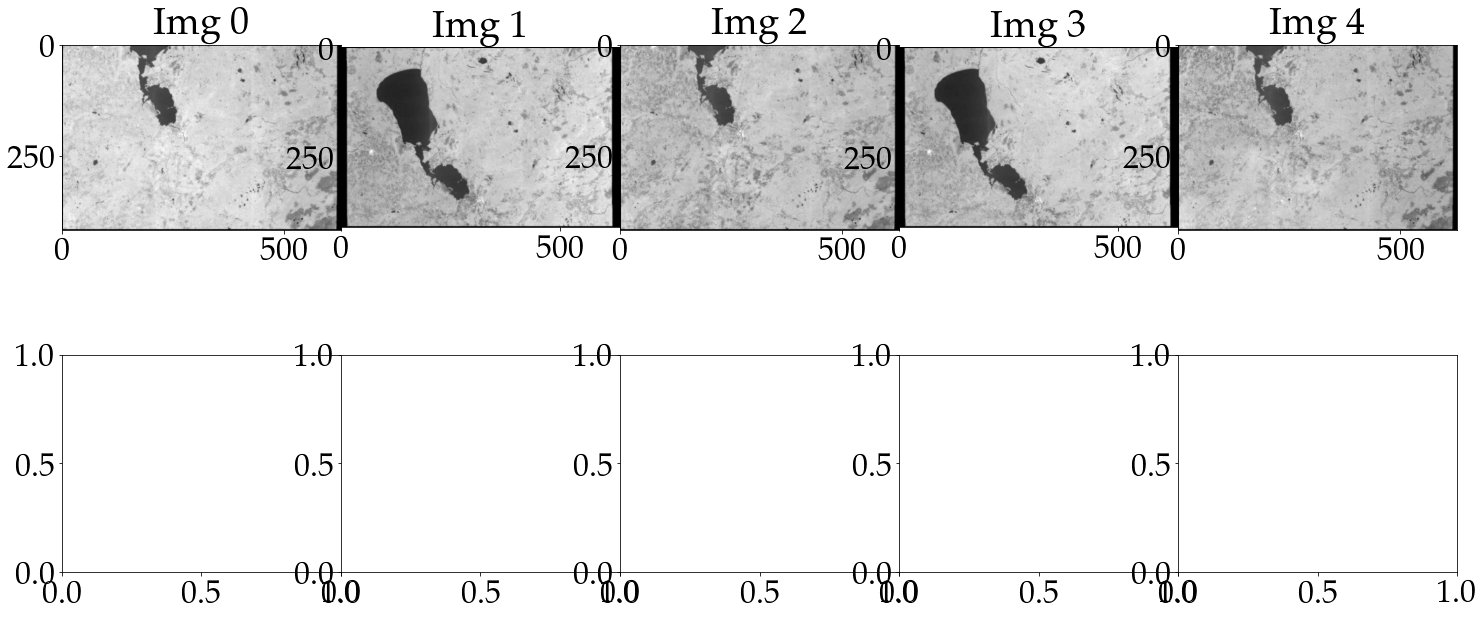

In [7]:
show_cross_pol_function(df_mgrs,5,username=os.getenv('COPERNICUS_HUP_USERNAME'),password=os.getenv('COPERNICUS_HUP_PASSWORD'))

## Download 

In [ ]:
folder = f'{os.getenv("raw_data_dir")}/test_folder'
with Satellite_download(met.products_df) as dwl:
    os.makedirs(folder, exist_ok=True)
    #save metadata
    dwl.products_df.to_pickle(f'{folder}/grd_dataframe.pkl')
    #download the thumbnails
    dwl.download_thumbnails(folder=f'{folder}/grd_thumbnails') 
    #download the entire image (grd) for some.. 
    dwl.download_sentinel_1(f'{folder}/grd')


## Load and calibrate

In [4]:
image_paths = glob.glob(f'{os.getenv("raw_data_dir")}/*/*/*.SAFE')
image_paths

['../../data/raw/sweden_data/grd/S1A_IW_GRDH_1SDV_20221008T045943_20221008T050008_045346_056BF3_0954.SAFE']

### Load Image

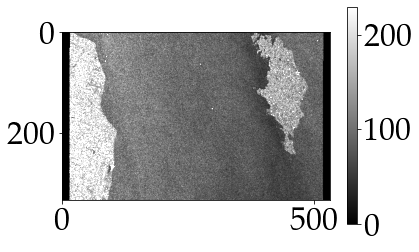

In [5]:
img = s1_load(image_paths[0])
img.simple_plot(band_index=0,stride=50)

### Radiometric calibration (really just dependant on incidence angle. Here gamma)

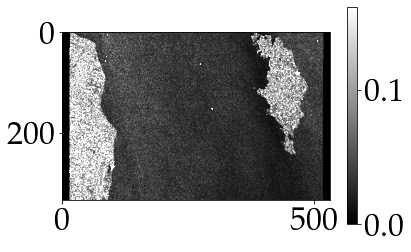

In [10]:
img =img.calibrate(mode='gamma') # could also use, e.g., 'sigma_0' 
img.simple_plot(band_index=0,stride=50)

It takes 130 seconds on my laptop to calibrate the entire image. 

### Speckle filtering.  Here the simplest, i.e., box filter

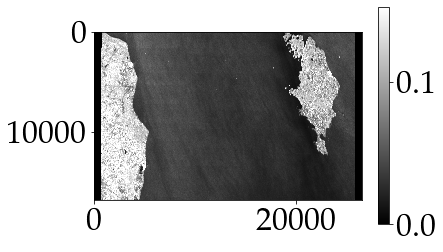

In [11]:
img = img.boxcar(5) #could easily make, e.g., a Lee filter..
img.simple_plot(band_index=0)

It takes 35 seconds on my laptop to perform box filerting on the entire image.

In [126]:
#import matplotlib.pyplot as plt
#diff = img.bands[1]-img_box.bands[1]
#plt.imshow(diff[::10,::10],cmap='gray',vmin=-0.001,vmax=0.001)
#plt.colorbar()

### Taking a subset

Now, lets say we know the position of, e.g., a ship (or another object) we might want to take that subset out:

In [12]:
indx = img.get_index(lat=57.0047,long=19.399)
print('index: ',indx)
#checking accuracy
print('coord: ',img.get_coordinate(indx[0],indx[1]))

index:  (9902, 15705)
coord:  (57.00469210530435, 19.39895965014322)


vh


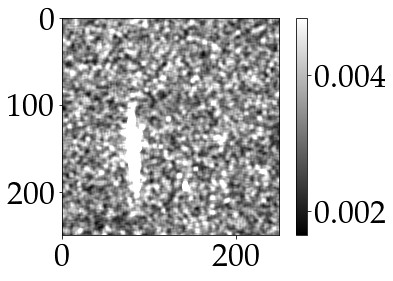

In [13]:
print('vh')
img[indx[0]-125:indx[0]+125,indx[1]-125:indx[1]+125].simple_plot(band_index=1)

vv


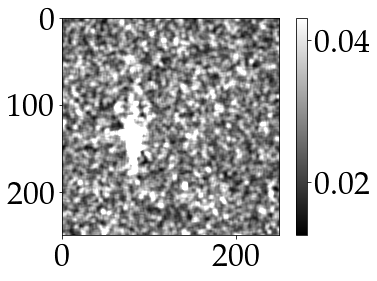

In [14]:
print('vv')
img[indx[0]-125:indx[0]+125,indx[1]-125:indx[1]+125].simple_plot(band_index=0)


In [15]:
subset = img[indx[0]-125:indx[0]+125,indx[1]-125:indx[1]+125]

In [16]:
subset

Mission: SENTINEL-1A 
 Bands: ['VV', 'VH']

In [17]:
subset.band_meta

[{'missionId': 'S1A',
  'productType': 'GRD',
  'polarisation': 'VV',
  'mode': 'IW',
  'swath': 'IW',
  'startTime': '2022-10-08T04:59:43.818129',
  'stopTime': '2022-10-08T05:00:08.816946',
  'absoluteOrbitNumber': '45346',
  'missionDataTakeId': '355315',
  'imageNumber': '001'},
 {'missionId': 'S1A',
  'productType': 'GRD',
  'polarisation': 'VH',
  'mode': 'IW',
  'swath': 'IW',
  'startTime': '2022-10-08T04:59:43.818129',
  'stopTime': '2022-10-08T05:00:08.816946',
  'absoluteOrbitNumber': '45346',
  'missionDataTakeId': '355315',
  'imageNumber': '002'}]

In [18]:
print(img.unit)

gamma
